In [242]:
%pylab inline
import numpy as np
import pylab
from scipy import stats

Populating the interactive namespace from numpy and matplotlib


/Users/aristidebaratin/anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [243]:
# Utilitaries
def sigmoid(z):
    return 1/(1+ np.exp(-z)) 

def lineSearch(f, grad, omega, L0):
    g= grad(omega)
    L=L0
    f_new = f(omega-1/L*g)
    while f_new >= f(omega) - 1/(2*L)*np.sum(g*g):
        L=2*L
        f_new = f(omega-1/L*g)
    return L
    
def nuSample(n, L):
    # L is list of of Lipschitz constants
    L=tuple(L)
    x=np.arange(n)
    dist = stats.rv_discrete(values=(x, L/np.sum(L)))
    return dist.rvs() 

In [244]:
# SAG algorithm with early re-weighting, exact regularization, uniform sampling. 
class SAG:
    
    def __init__(self, f, fi, grad, n):
        self.f = f  # regularized Function to minimize
        self.fi = fi # function for each example i
        self.grad = grad  # gradients of fi 
        self.n = n
        
    def train(self, omega0, alpha, l_reg, NUS, tolerance = 10**(-6), max_pass=50):
        self.max_pass = max_pass
        omega = omega0
        d=0
        C = [0]*self.n
        grad = [0]*self.n
        m=0
        change = True
        n_iter = 0
        logs = []
        L=[1]*self.n
        while change and n_iter < max_pass*self.n:
            n_iter+=1
            f_old = self.f(omega)
            # sample exampe i 
            if NUS:
                i = nuSample(self.n, L)
            else:
                i=np.random.choice(self.n)
            if C[i] == 0:
                m+=1
                C[i]=1
            # update direction 
            new_grad = self.grad(omega, i)
            d += new_grad - grad[i]
            # update gradients
            grad[i] = new_grad
            if np.sum(new_grad*new_grad)>10**(-8):
                def f_i(omega):
                    return self.fi(omega,i)
                def grad_i(omega):
                    return self.grad(omega, i)
                L[i]=lineSearch(f_i, grad_i, omega, L0=L[i])
            # update parameters
            #alpha = 1/(L[i] + l_reg)
            omega -= alpha*(1/m*d + l_reg*omega)
            L[i] = L[i]/2*(1/self.n)
            f_new = self.f(omega)
            if n_iter% self.n==0:
                logs+=[f_new]
            relative_change = np.abs((f_new - f_old)/f_old)
            change = relative_change > tolerance
            
        if change:
            print("SAG terminated without convergence")
        else:
            print("SAG converged after", n_iter, """iterations. 
                  The value obtained for the vector omega is {0} and for the bias b is {1}""".format(omega[:-1], omega[-1]))
        
        return omega, logs    

In [245]:
class Logistic_reg:
    
    def __init__(self, max_pass=50):
        self.max_pass = max_pass
        
    def train(self, train_data, omega0, alpha = 0.05, l_reg=0, NUS=False):
        # Bias feature trick
        X = np.ones(train_data.shape)
        X[:,:-1] = train_data[:,:-1]
        Y = train_data[:,-1]
        n = train_data.shape[0]
        self.omega0 = omega0
        
        def f(omega):
            mu = sigmoid(np.dot(X, omega))
            f = - 1/X.shape[0]*(np.dot(Y,np.log(mu)) + np.dot(1-Y, np.log(1-mu))) + 1/2*l_reg*np.sum(omega[:-1]**2)
            return f
        
        def fi(omega, i):
            mu = sigmoid(np.dot(X[i], omega))
            f = - Y[i]*np.log(mu) - (1-Y[i])*np.log(1-mu) 
            return f
    
        # compute the non regularized gradient i
        def grad(omega, i):
            mu = sigmoid(np.dot(X[i], omega))
            return (mu-Y[i])*X[i] 
             
        # Run SAG 
        sag = SAG(f, fi,  grad, X.shape[0])
        self.omega, self.logs = sag.train(self.omega0, alpha, l_reg, NUS)     

In [246]:
# load iris dataset
iris = np.loadtxt('iris.txt')
data = iris
# We keep label 1 and 2
data = data[data[:,-1]<3,:]
# We change label 2 into label 0 
data[data[:,-1]==2,-1] = 0

X = np.ones(data.shape)
X[:,:-1] = data[:,:-1]
    
l_reg = 1/X.shape[0]
# Lipschitz constant of f
L = 0.25*np.max(np.sum(X**2, axis=1)) + l_reg
# Convexity constant of f
l = 0.25*np.min(np.sum(X**2, axis=1)) + l_reg

In [251]:
omega0 = np.ones(data.shape[1])
model = Logistic_reg()
model.train(data, omega0, l_reg)
logs = model.logs

/Users/aristidebaratin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/Users/aristidebaratin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log
/Users/aristidebaratin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in double_scalars


SAG terminated without convergence


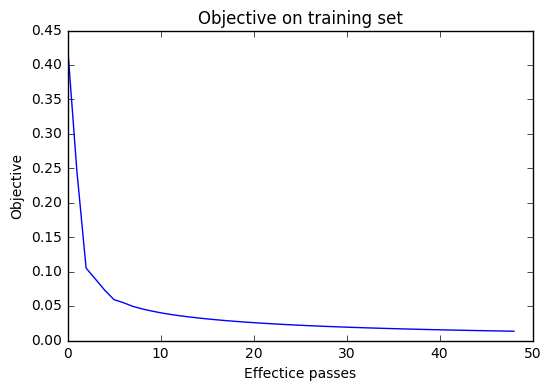

In [252]:
import matplotlib.pyplot as plt
pylab.plot(list(np.arange(len(logs)-1)), logs[1:])
pylab.ylabel('Objective')
pylab.xlabel('Effectice passes')
pylab.title('Objective on training set')
pylab.show()



    